Mounted at /content/drive


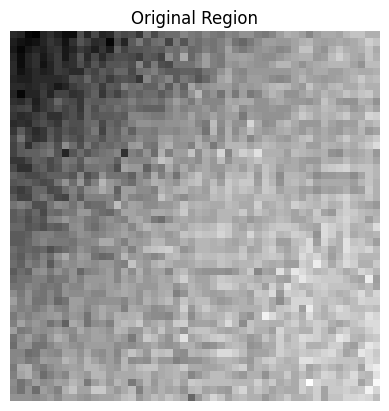

Encoded Data:
Huffman: 00000011001100000110101001101011011001101001100011111000111110100111110100101001100110000010110011000000001111000001001010001111110010100001011111011111111111111000010110010111000010110010111000011100100010001110010111100010001101111010001100010001110111010101011000100011101110101111100011111011011111010011111011110011001111110000000111110111001100011110110011100000010011000000110100000101100110100111010110111101111110010111001110101101111001011111111010110010101110010000101111110010111111010001000011001101010110110111010100010101110101011101011001000001000011000000110100000110011001100111110010011000111111000011001100110000011110011000111110001111110111110011001011001110111100111101001111100101001110010111111101110111110111111011100010101110101011000010111100001000110010011000111101010000100011000010011010001110111101101000111101100110011111010110011010011000000110000000000001110000110010011000111100000000000100000001100111010100010100000010000011110011101111011

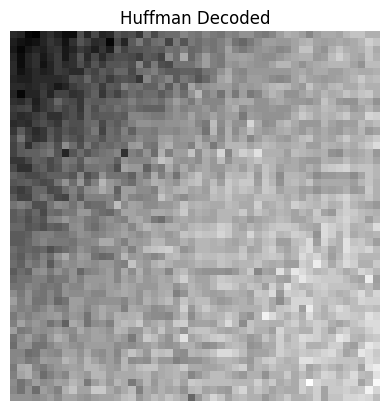

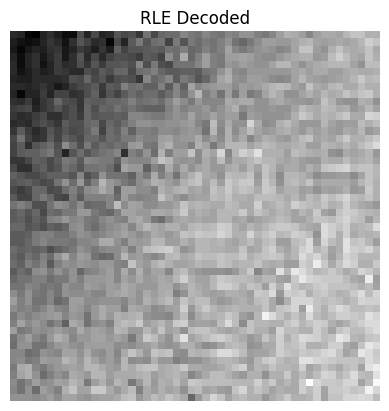

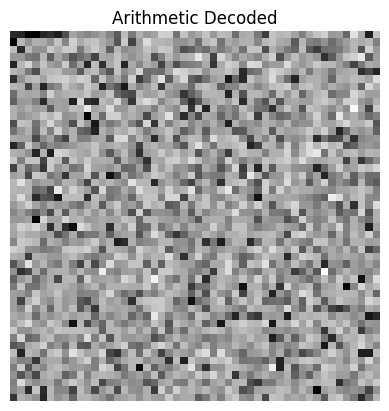

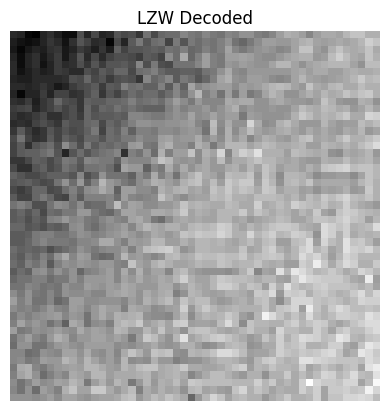

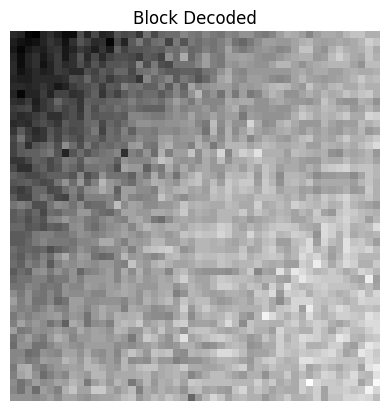

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
import heapq
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load image
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Failed to load image.")
    return image

# Extract a small portion of the image
def extract_region(image, size=(50, 50)):
    return image[:size[0], :size[1]]

# Convert image portion to a string for coding algorithms
def image_to_string(region):
    return ''.join(chr(pixel) for row in region for pixel in row)

# Convert string back to image
def string_to_image(encoded_string, original_shape):
    return np.array([ord(char) for char in encoded_string]).reshape(original_shape)

# Huffman Coding
class HuffmanNode:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(text):
    freq = defaultdict(int)
    for char in text:
        freq[char] += 1
    heap = [HuffmanNode(char, freq) for char, freq in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)
    return heap[0]

def build_codes(node, prefix="", code_map={}):
    if node:
        if node.char is not None:
            code_map[node.char] = prefix
        build_codes(node.left, prefix + "0", code_map)
        build_codes(node.right, prefix + "1", code_map)
    return code_map

def huffman_encoding(text):
    root = build_huffman_tree(text)
    code_map = build_codes(root)
    encoded_text = ''.join(code_map[char] for char in text)
    return encoded_text, code_map

def huffman_decoding(encoded_text, code_map):
    reverse_map = {v: k for k, v in code_map.items()}
    current_code = ""
    decoded_text = ""
    for bit in encoded_text:
        current_code += bit
        if current_code in reverse_map:
            decoded_text += reverse_map[current_code]
            current_code = ""
    return decoded_text

# Run-Length Encoding (RLE)
def rle_encoding(text):
    encoded = []
    i = 0
    while i < len(text):
        count = 1
        while i + 1 < len(text) and text[i] == text[i + 1]:
            count += 1
            i += 1
        encoded.append((text[i], count))
        i += 1
    return encoded

def rle_decoding(encoded):
    return ''.join(char * count for char, count in encoded)

# Arithmetic Coding
def arithmetic_coding(text):
    freq = defaultdict(int)
    for char in text:
        freq[char] += 1
    total_count = len(text)
    prob_ranges = {}
    low = 0.0
    for char, count in sorted(freq.items()):
        high = low + count / total_count
        prob_ranges[char] = (low, high)
        low = high

    # Encoding
    low, high = 0.0, 1.0
    for char in text:
        char_low, char_high = prob_ranges[char]
        range_width = high - low
        high = low + range_width * char_high
        low = low + range_width * char_low
    return (low + high) / 2, prob_ranges

def arithmetic_decoding(encoded_value, prob_ranges, length):
    text = ""
    for _ in range(length):
        for char, (low, high) in prob_ranges.items():
            if low <= encoded_value < high:
                text += char
                encoded_value = (encoded_value - low) / (high - low)
                break
    return text

# LZW Coding
def lzw_encoding(text):
    dictionary = {chr(i): i for i in range(256)}
    next_code = 256
    current = ""
    encoded = []
    for char in text:
        temp = current + char
        if temp in dictionary:
            current = temp
        else:
            encoded.append(dictionary[current])
            dictionary[temp] = next_code
            next_code += 1
            current = char
    if current:
        encoded.append(dictionary[current])
    return encoded

def lzw_decoding(encoded):
    dictionary = {i: chr(i) for i in range(256)}
    next_code = 256
    current = chr(encoded[0])
    decoded = current
    for code in encoded[1:]:
        if code in dictionary:
            entry = dictionary[code]
        elif code == next_code:
            entry = current + current[0]
        decoded += entry
        dictionary[next_code] = current + entry[0]
        next_code += 1
        current = entry
    return decoded

# Block Coding
def block_coding(text, block_size=8):
    blocks = [text[i:i + block_size] for i in range(0, len(text), block_size)]
    encoded = [''.join(f"{ord(char):08b}" for char in block) for block in blocks]
    return encoded

def block_decoding(encoded, block_size=8):
    decoded = ''.join(chr(int(block[i:i + 8], 2)) for block in encoded for i in range(0, len(block), 8))
    return decoded

# Main Function
if __name__ == "__main__":
    # Update with the correct path for your image in Google Drive
    image_path = '/content/drive/MyDrive/CAT.jpg'
    image = load_image(image_path)
    region = extract_region(image)

    # Display the original region
    plt.imshow(region, cmap='gray')
    plt.title("Original Region")
    plt.axis('off')
    plt.show()

    # Convert region to string
    text = image_to_string(region)
    original_shape = region.shape

    # Huffman Encoding
    huffman_encoded, huffman_code_map = huffman_encoding(text)
    huffman_decoded = huffman_decoding(huffman_encoded, huffman_code_map)

    # Run-Length Encoding
    rle_encoded = rle_encoding(text)
    rle_decoded = rle_decoding(rle_encoded)

    # Arithmetic Coding
    arithmetic_encoded, prob_ranges = arithmetic_coding(text)
    arithmetic_decoded = arithmetic_decoding(arithmetic_encoded, prob_ranges, len(text))

    # LZW Encoding
    lzw_encoded = lzw_encoding(text)
    lzw_decoded = lzw_decoding(lzw_encoded)

    # Block Coding
    block_encoded = block_coding(text)
    block_decoded = block_decoding(block_encoded)

    # Display Encoded Data
    print("Encoded Data:")
    print(f"Huffman: {huffman_encoded}")
    print(f"RLE: {rle_encoded}")
    print(f"Arithmetic: {arithmetic_encoded}")
    print(f"LZW: {lzw_encoded}")
    print(f"Block: {block_encoded}")

    # Display Results
    results = [huffman_decoded, rle_decoded, arithmetic_decoded, lzw_decoded, block_decoded]
    titles = ['Huffman', 'RLE', 'Arithmetic', 'LZW', 'Block']

    for title, result in zip(titles, results):
        decoded_image = string_to_image(result, original_shape)
        plt.imshow(decoded_image, cmap='gray')
        plt.title(f"{title} Decoded")
        plt.axis('off')
        plt.show()
